In [ ]:
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/San_Jose_Traffic_Pred/pems_bay_speed_0.csv")

## EDA

In [ ]:
# Remove the first 192 rows
data = data.iloc[192:]

In [ ]:
data.head()

,Unnamed: 0,400001,400017,400030,400040,400045,400052,400057,400059,400065,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
192,2023-01-01 16:00:00,71.5,65.1,61.6,65.1,65.3,66.8,62.6,66.6,67.3,...,68.5,61.9,67.2,64.1,66.3,61.5,68.4,69.6,69.5,64.5
193,2023-01-01 16:05:00,71.1,65.4,62.3,64.6,66.1,67.1,64.3,67.1,67.1,...,69.0,62.1,67.3,64.4,66.6,59.9,68.1,69.6,69.2,64.5
194,2023-01-01 16:10:00,70.5,64.7,61.6,64.9,66.6,67.2,65.1,66.5,66.9,...,68.2,61.9,67.1,64.0,66.4,60.6,69.4,70.6,70.4,64.9
195,2023-01-01 16:15:00,70.8,64.5,60.8,65.0,66.0,67.0,65.4,66.9,65.8,...,68.7,62.0,66.6,64.1,66.4,61.0,69.4,70.0,69.6,65.0
196,2023-01-01 16:20:00,70.6,64.4,60.0,65.4,66.2,66.6,64.9,66.9,66.6,...,68.9,62.0,67.0,64.3,66.5,60.6,68.5,69.8,68.9,64.5


In [ ]:
# Rename the column
data.rename(columns={'Unnamed: 0': 'time'}, inplace=True)

# Set the 'time' column as the index
data.set_index('time', inplace=True)

# Convert the index into a proper datetime format
data.index = pd.to_datetime(data.index)

### Sensor 400017

In [ ]:
# Check for missing values
missing_values = data['400017'].isnull().sum()
print(f"Number of missing values: {missing_values}")

Number of missing values: 0


In [ ]:
# Extract time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

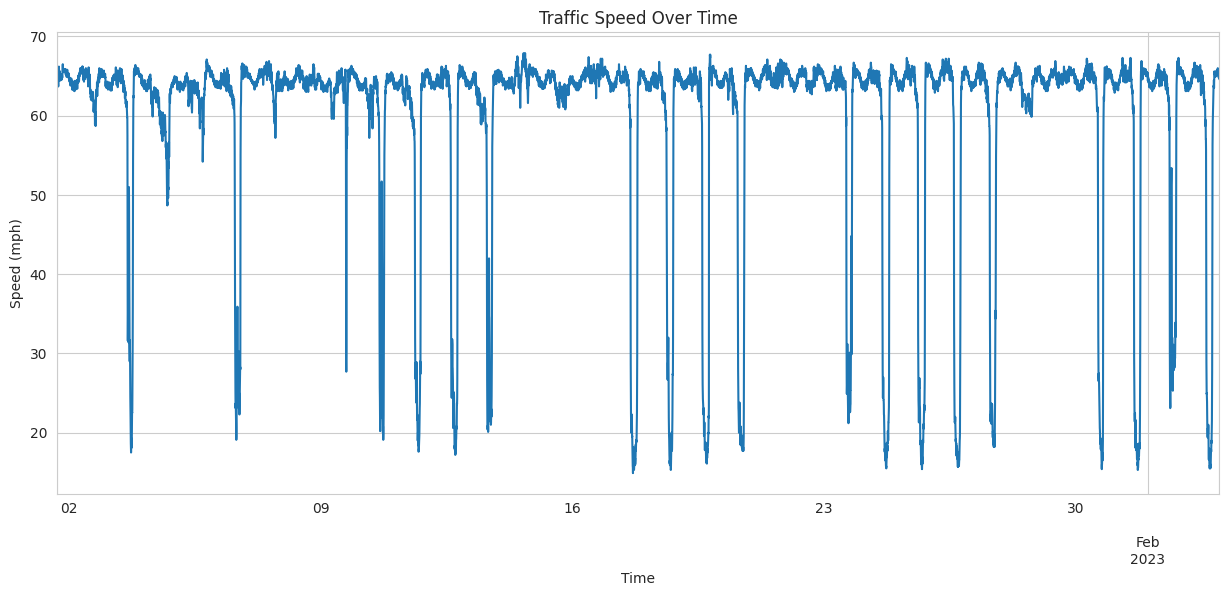

In [ ]:
sns.set_style("whitegrid")

# 1. Time Series Plot
plt.figure(figsize=(15, 6))
data['400017'].plot()
plt.title('Traffic Speed Over time')
plt.ylabel('Speed (mph)')
plt.xlabel('Time')
plt.show()


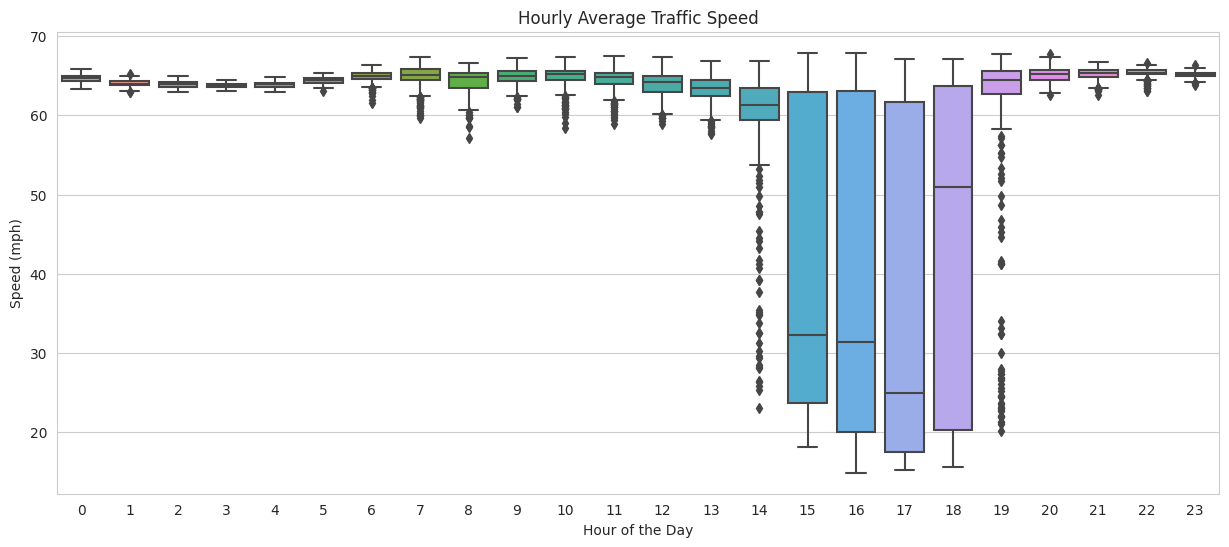

In [ ]:
# 2. Hourly Average Speed
plt.figure(figsize=(15, 6))
sns.boxplot(x=data['hour'], y=data['400017'])
plt.title('Hourly Average Traffic Speed')
plt.ylabel('Speed (mph)')
plt.xlabel('Hour of the Day')
plt.show()

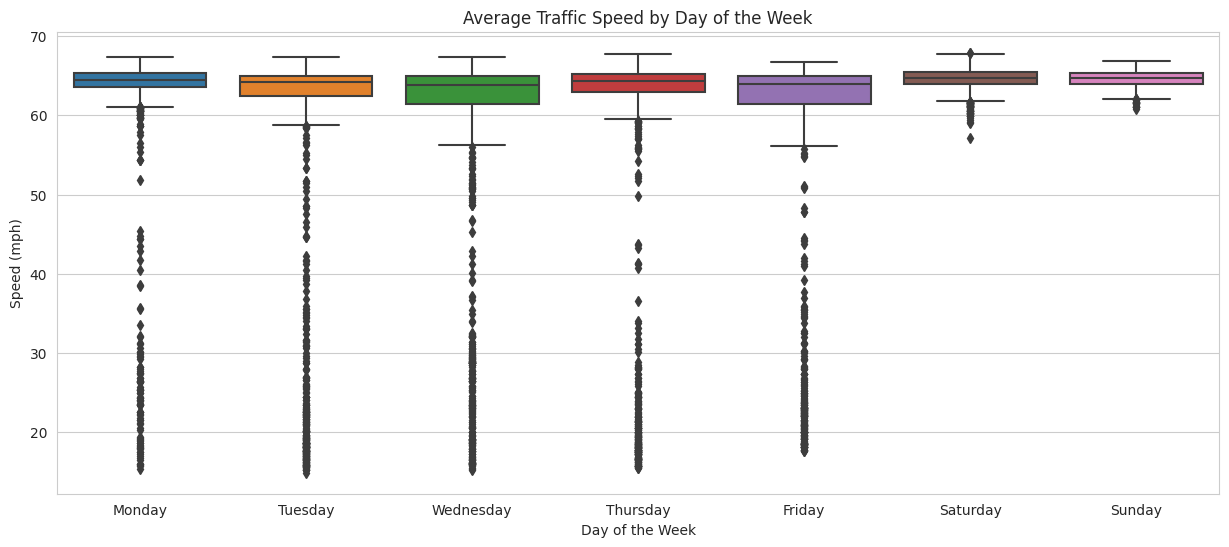

In [ ]:
# 3. Average Speed by Day of the Week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(15, 6))
sns.boxplot(x=data['day_of_week'], y=data['400017'])
plt.title('Average Traffic Speed by Day of the Week')
plt.ylabel('Speed (mph)')
plt.xlabel('Day of the Week')
plt.xticks(ticks=range(7), labels=days)
plt.show()

### Average over the bay area

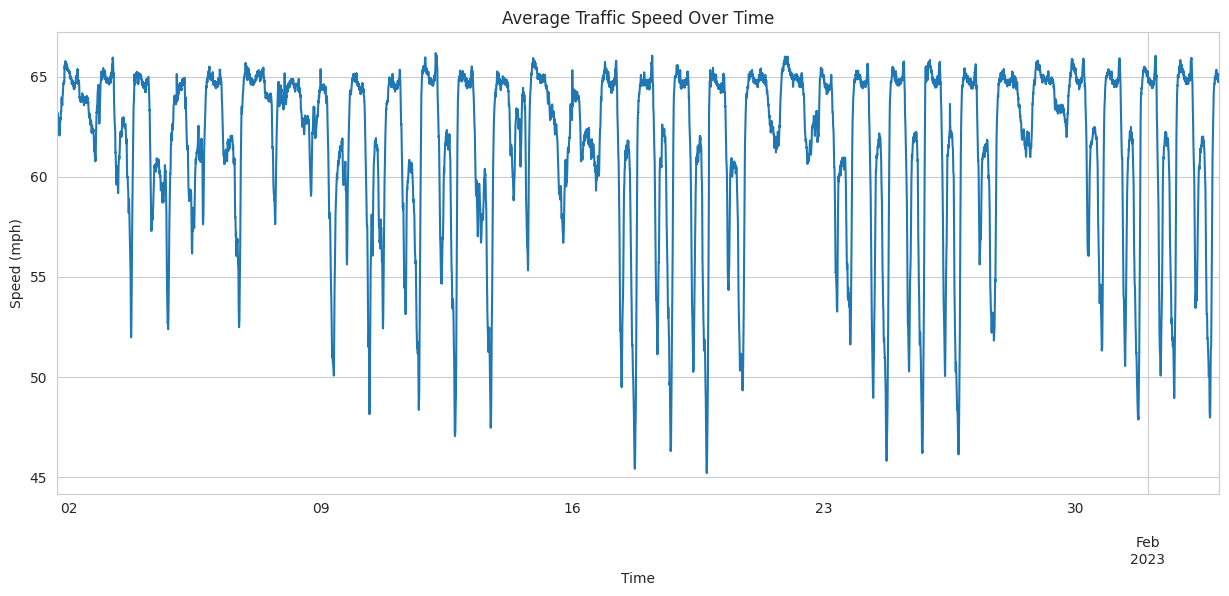

In [ ]:
# Calculate the average speed across all sensors for each timestamp
data['average_speed'] = data.mean(axis=1)

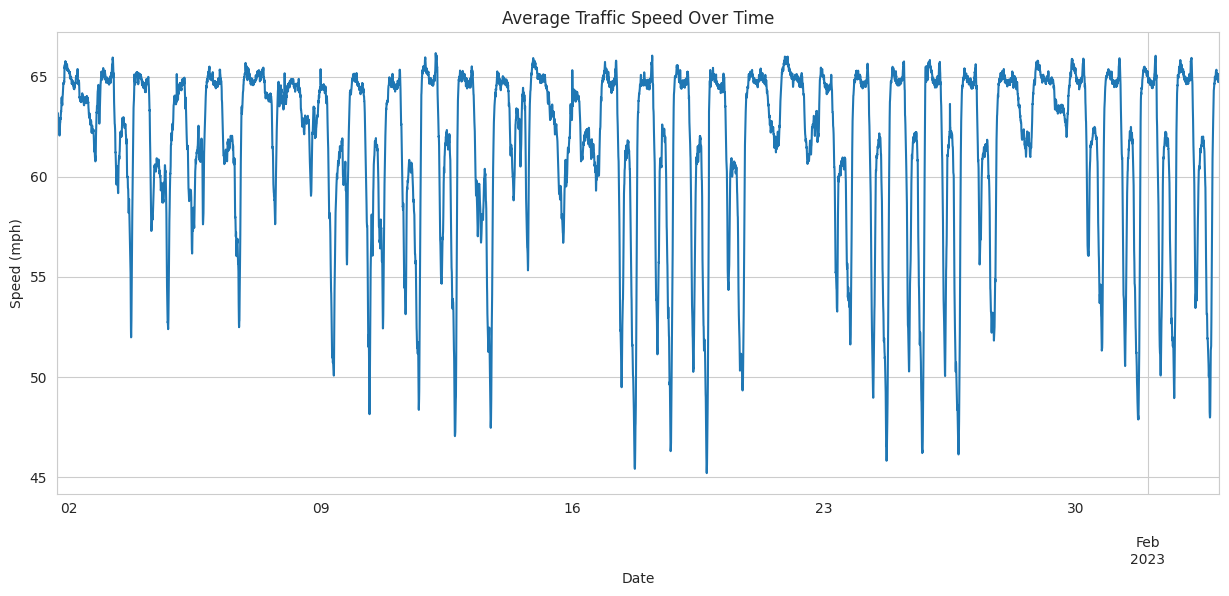

In [ ]:
# 1. Time Series Plot for Average Speed
plt.figure(figsize=(15, 6))
data['average_speed'].plot()
plt.title('Average Traffic Speed Over Time')
plt.ylabel('Speed (mph)')
plt.xlabel('Date')
plt.show()

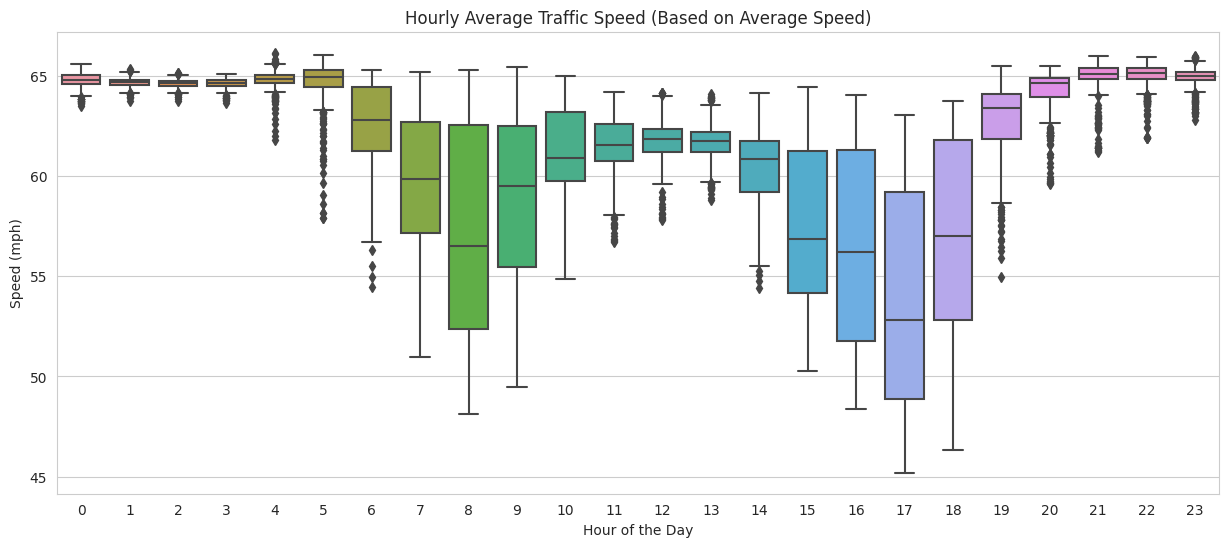

In [ ]:
# 2. Hourly Average Speed based on Average Speed
plt.figure(figsize=(15, 6))
sns.boxplot(x=data['hour'], y=data['average_speed'])
plt.title('Hourly Average Traffic Speed (Based on Average Speed)')
plt.ylabel('Speed (mph)')
plt.xlabel('Hour of the Day')
plt.show()

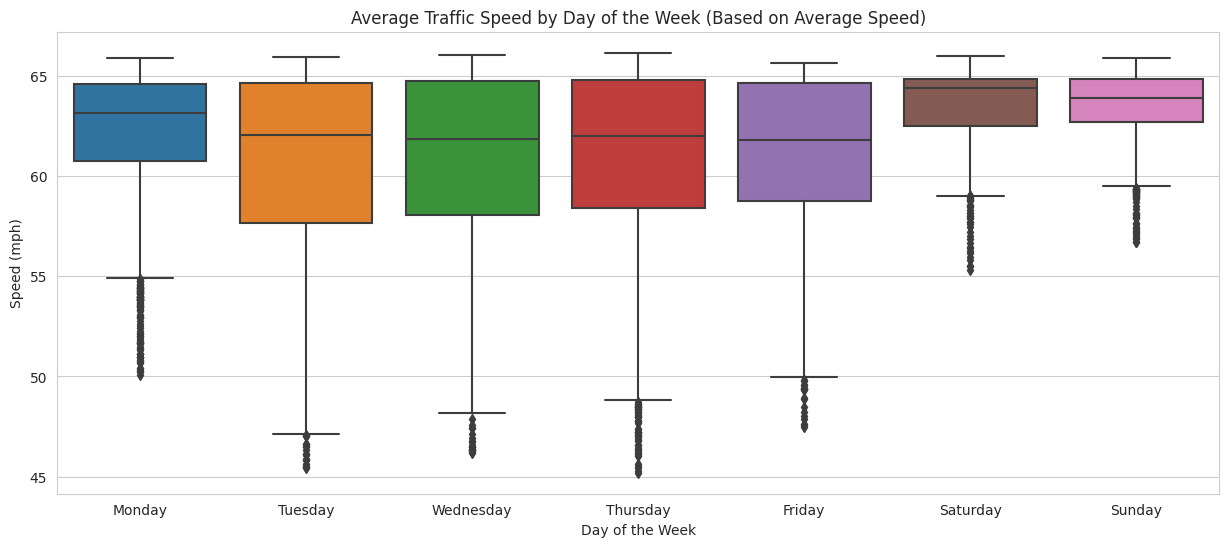

In [ ]:
# 3. Average Speed by Day of the Week based on Average Speed
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(15, 6))
sns.boxplot(x=data['day_of_week'], y=data['average_speed'])
plt.title('Average Traffic Speed by Day of the Week (Based on Average Speed)')
plt.ylabel('Speed (mph)')
plt.xlabel('Day of the Week')
plt.xticks(ticks=range(7), labels=days)
plt.show()

## Merge speed and flow

In [ ]:
speed_data=pd.read_csv("/content/drive/MyDrive/San_Jose_Traffic_Pred/pems_bay_speed_0.csv")
flow_data=pd.read_csv("/content/drive/MyDrive/San_Jose_Traffic_Pred/pems_bay_flow_0.csv")

In [ ]:
# Ensure the data is sorted by the index to maintain chronological order
speed_data = speed_data.sort_index()
flow_data = flow_data.sort_index()

# Merge datasets on the index
combined_data = speed_data.join(flow_data, how='inner', lsuffix='_speed', rsuffix='_flow')

In [ ]:
combined_data.head()

,Unnamed: 0_speed,400001_speed,400017_speed,400030_speed,400040_speed,400045_speed,400052_speed,400057_speed,400059_speed,400065_speed,...,409525_flow,409526_flow,409528_flow,409529_flow,413026_flow,413845_flow,413877_flow,413878_flow,414284_flow,414694_flow
0,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-01-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Remove the first 192 rows
combined_data = combined_data.iloc[192:]

In [ ]:
# Rename the column
combined_data.rename(columns={'Unnamed: 0_speed': 'time'}, inplace=True)

# Set the 'time' column as the index
combined_data.set_index('time', inplace=True)

# Convert the index into a proper datetime format
combined_data.index = pd.to_datetime(data.index)

# Check the first few rows to confirm
combined_data.head()

,400001_speed,400017_speed,400030_speed,400040_speed,400045_speed,400052_speed,400057_speed,400059_speed,400065_speed,400069_speed,...,409525_flow,409526_flow,409528_flow,409529_flow,413026_flow,413845_flow,413877_flow,413878_flow,414284_flow,414694_flow
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 16:00:00,71.5,65.1,61.6,65.1,65.3,66.8,62.6,66.6,67.3,51.8,...,44.0,77.0,70.0,103.0,403.0,245.0,369.0,266.0,286.0,387.0
2023-01-01 16:05:00,71.1,65.4,62.3,64.6,66.1,67.1,64.3,67.1,67.1,50.6,...,68.0,90.0,102.0,126.0,325.0,189.0,377.0,252.0,278.0,404.0
2023-01-01 16:10:00,70.5,64.7,61.6,64.9,66.6,67.2,65.1,66.5,66.9,50.8,...,50.0,85.0,76.0,105.0,371.0,217.0,394.0,268.0,294.0,399.0
2023-01-01 16:15:00,70.8,64.5,60.8,65.0,66.0,67.0,65.4,66.9,65.8,49.9,...,57.0,84.0,85.0,112.0,379.0,228.0,360.0,256.0,276.0,372.0
2023-01-01 16:20:00,70.6,64.4,60.0,65.4,66.2,66.6,64.9,66.9,66.6,51.5,...,61.0,87.0,88.0,115.0,360.0,223.0,371.0,254.0,272.0,388.0


## combined data EDA

In [ ]:
# Calculate average speed and average flow
combined_data['average_speed'] = combined_data.filter(like='_speed').mean(axis=1)
combined_data['average_flow'] = combined_data.filter(like='_flow').mean(axis=1)

<ipython-input-41-8b9e11ac19cf>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined_data['average_flow'] = combined_data.filter(like='_flow').mean(axis=1)


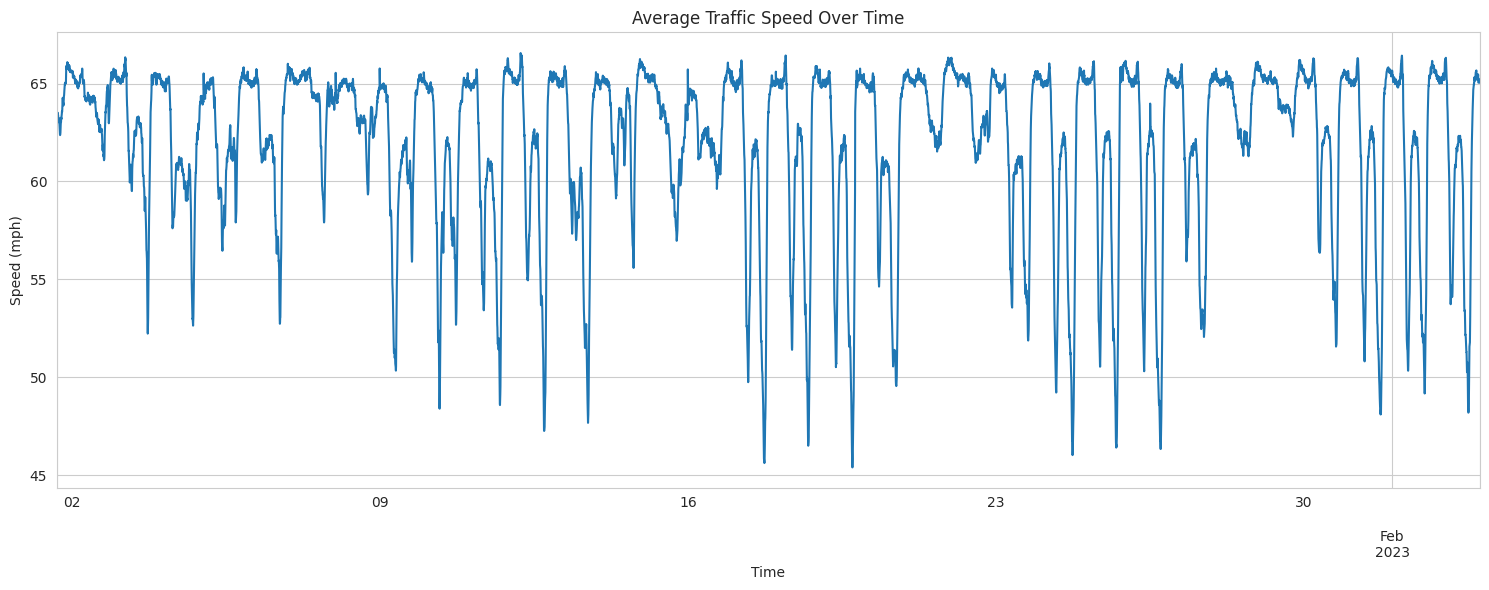

In [ ]:
# 1. Time Series Plot for Average Speed
plt.figure(figsize=(15, 6))
combined_data['average_speed'].plot()
plt.title('Average Traffic Speed Over Time')
plt.ylabel('Speed (mph)')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

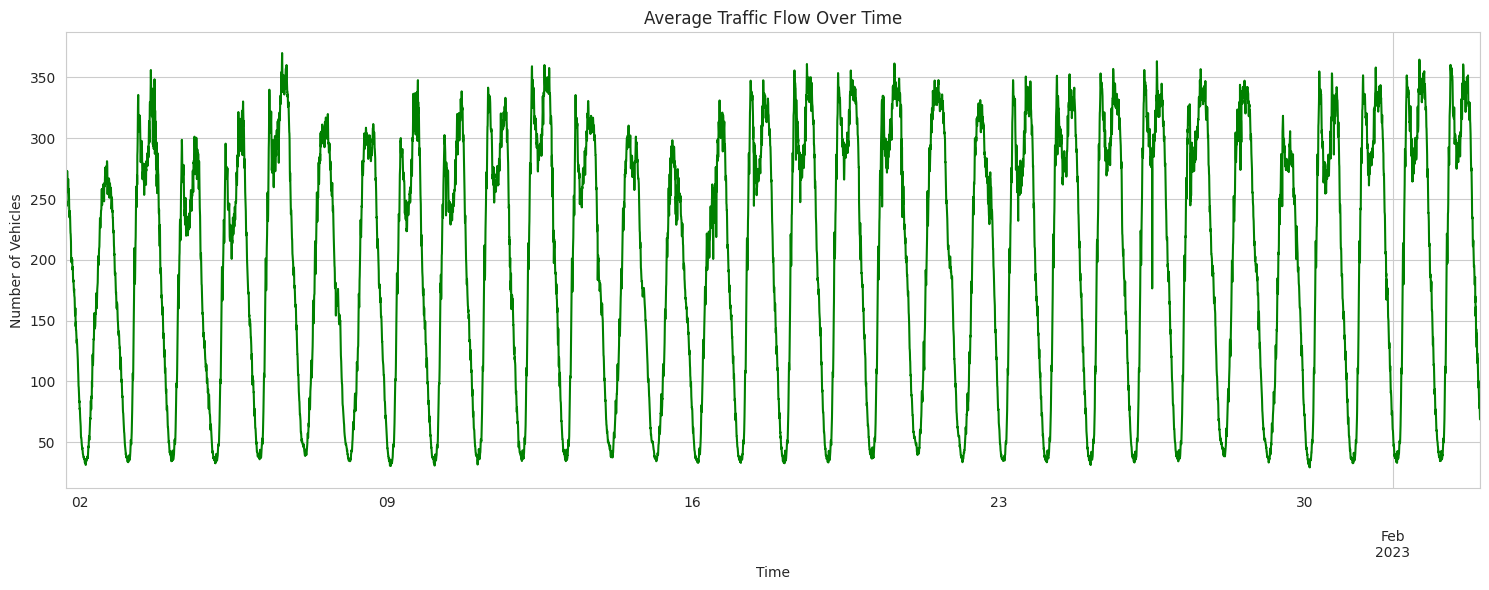

In [ ]:
# 2. Time Series Plot for Average Flow
plt.figure(figsize=(15, 6))
combined_data['average_flow'].plot(color='green')
plt.title('Average Traffic Flow Over Time')
plt.ylabel('Number of Vehicles')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

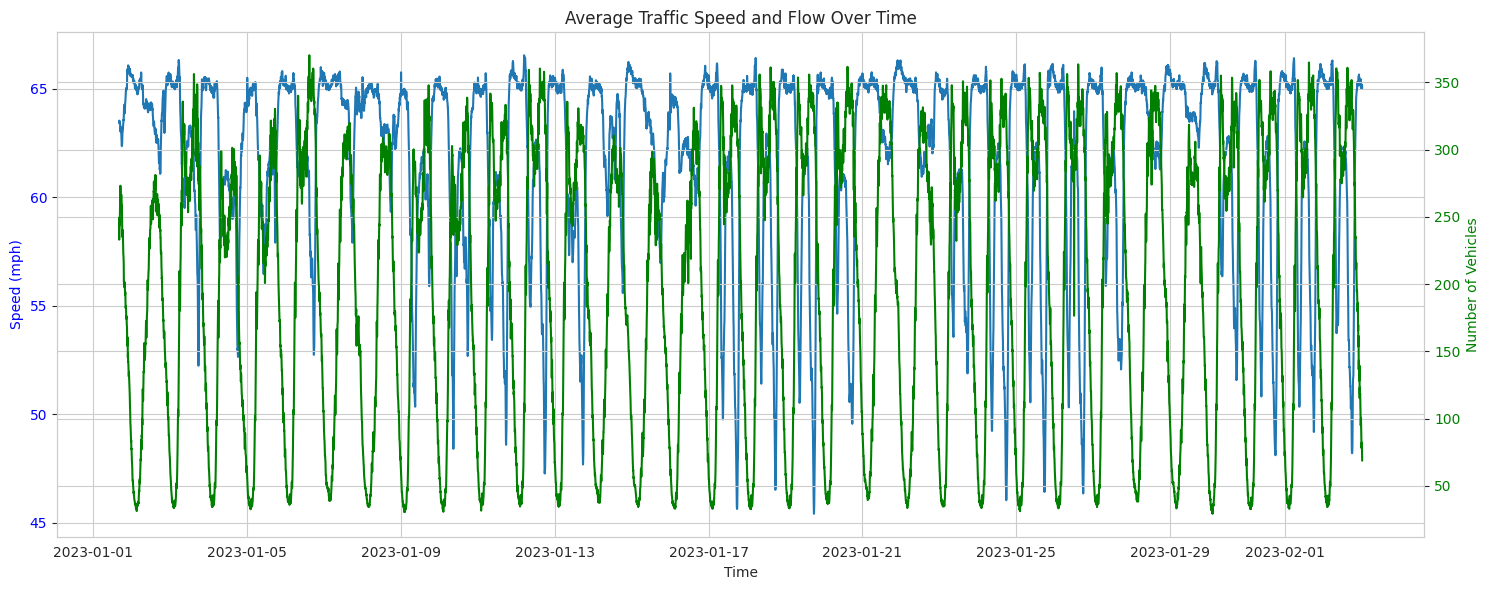

In [ ]:
plt.figure(figsize=(15, 6))

# Plotting average speed on the left y-axis
ax1 = plt.gca()  # get current axis
ax1.plot(combined_data.index, combined_data['average_speed'], label='Average Speed')
ax1.set_ylabel('Speed (mph)', color='blue')
ax1.set_xlabel('Time')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Average Traffic Speed and Flow Over Time')

# Creating a second y-axis for plotting average flow
ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis
ax2.plot(combined_data.index, combined_data['average_flow'], color='green', label='Average Flow')
ax2.set_ylabel('Number of Vehicles', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Showing the plot
plt.tight_layout()
plt.show()

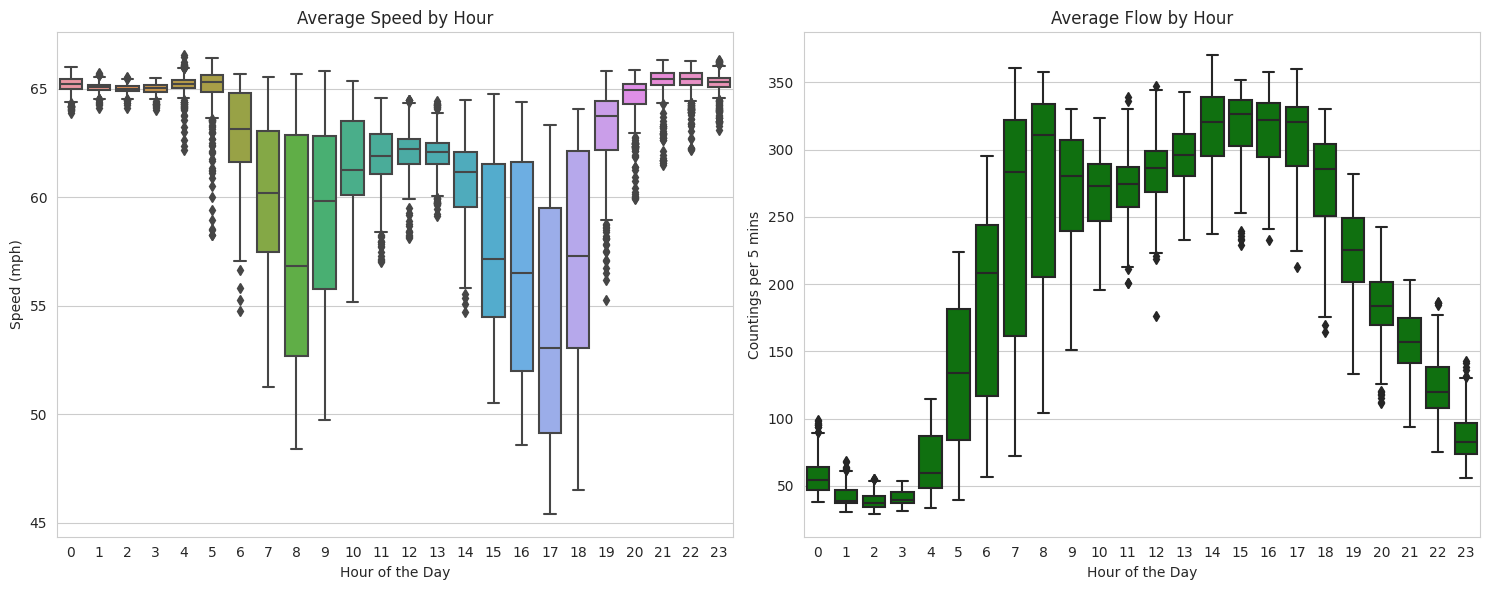

In [ ]:
combined_data['hour'] = combined_data.index.hour
plt.figure(figsize=(15, 6))

# Box plot for average speed by hour
plt.subplot(1, 2, 1)
sns.boxplot(x='hour', y='average_speed', data=combined_data)
plt.title('Average Speed by Hour')
plt.ylabel('Speed (mph)')
plt.xlabel('Hour of the Day')

# Box plot for average flow by hour
plt.subplot(1, 2, 2)
sns.boxplot(x='hour', y='average_flow', data=combined_data, color='green')
plt.title('Average Flow by Hour')
plt.ylabel('Countings per 5 mins')
plt.xlabel('Hour of the Day')

plt.tight_layout()
plt.show()


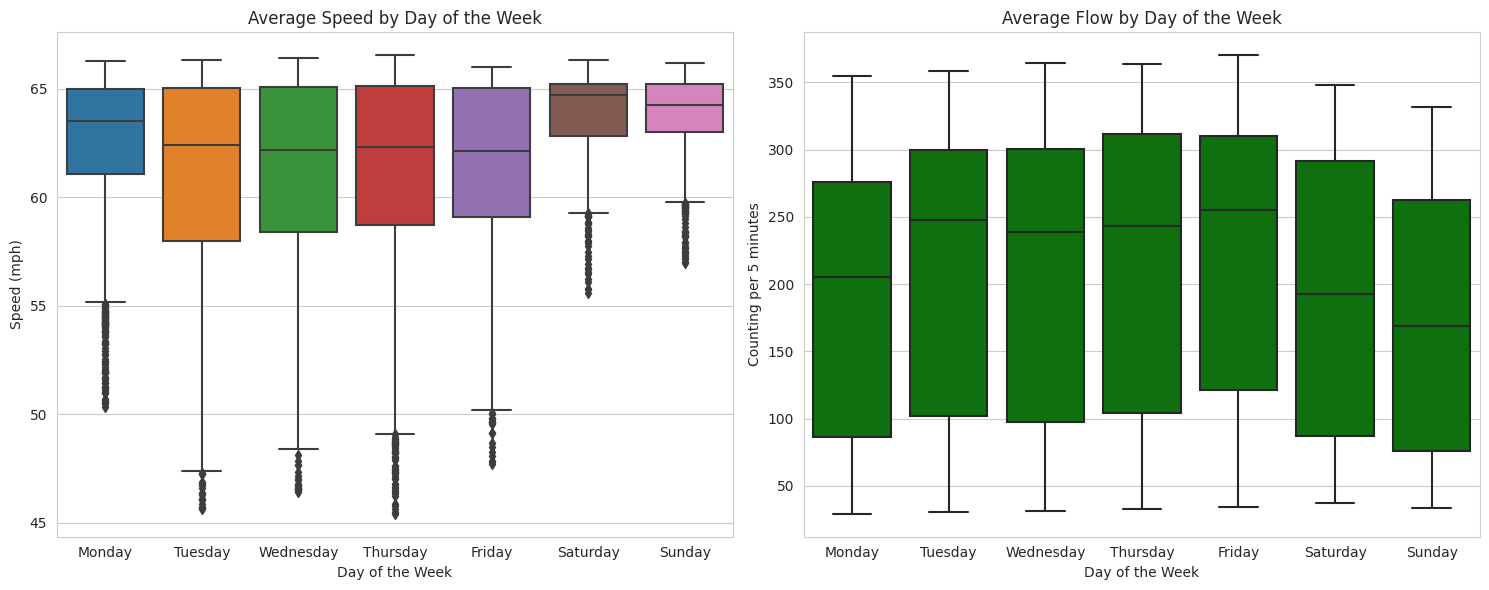

In [ ]:
combined_data['day_of_week'] = combined_data.index.dayofweek
plt.figure(figsize=(15, 6))

# Define the day of the week labels
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Box plot for average speed by day of the week
plt.subplot(1, 2, 1)
sns.boxplot(x='day_of_week', y='average_speed', data=combined_data)
plt.title('Average Speed by Day of the Week')
plt.ylabel('Speed (mph)')
plt.xlabel('Day of the Week')
plt.xticks(ticks=range(7), labels=days)

# Box plot for average flow by day of the week
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='average_flow', data=combined_data, color='green')
plt.title('Average Flow by Day of the Week')
plt.ylabel('Counting per 5 minutes')
plt.xlabel('Day of the Week')
plt.xticks(ticks=range(7), labels=days)

plt.tight_layout()
plt.show()



## Modeling

In [ ]:
combined_data.head()

,400001_speed,400017_speed,400030_speed,400040_speed,400045_speed,400052_speed,400057_speed,400059_speed,400065_speed,400069_speed,...,409525_flow,409526_flow,409528_flow,409529_flow,413026_flow,413845_flow,413877_flow,413878_flow,414284_flow,414694_flow
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 16:00:00,71.5,65.1,61.6,65.1,65.3,66.8,62.6,66.6,67.3,51.8,...,44.0,77.0,70.0,103.0,403.0,245.0,369.0,266.0,286.0,387.0
2023-01-01 16:05:00,71.1,65.4,62.3,64.6,66.1,67.1,64.3,67.1,67.1,50.6,...,68.0,90.0,102.0,126.0,325.0,189.0,377.0,252.0,278.0,404.0
2023-01-01 16:10:00,70.5,64.7,61.6,64.9,66.6,67.2,65.1,66.5,66.9,50.8,...,50.0,85.0,76.0,105.0,371.0,217.0,394.0,268.0,294.0,399.0
2023-01-01 16:15:00,70.8,64.5,60.8,65.0,66.0,67.0,65.4,66.9,65.8,49.9,...,57.0,84.0,85.0,112.0,379.0,228.0,360.0,256.0,276.0,372.0
2023-01-01 16:20:00,70.6,64.4,60.0,65.4,66.2,66.6,64.9,66.9,66.6,51.5,...,61.0,87.0,88.0,115.0,360.0,223.0,371.0,254.0,272.0,388.0


In [ ]:
combined_data.to_csv('/content/drive/MyDrive/San_Jose_Traffic_Pred/combined_data.csv', index=False)

In [ ]:
# Extracting speed and flow for sensor 400017
data_400017 = combined_data[['400017_speed', '400017_flow']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_400017)


In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        X.append(seq[:-1])
        y.append(seq[-1])

    return np.array(X), np.array(y)

# Choose a sequence length (e.g., 10 time steps)
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
train_size = int(len(X) * 0.67)  # Taking 67% of data for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(LSTM(units=50))
model.add(Dense(units=2))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
195/195 [==============================] - 11s 29ms/step - loss: 0.0283 - val_loss: 0.0078
Epoch 2/20
195/195 [==============================] - 3s 16ms/step - loss: 0.0051 - val_loss: 0.0081
Epoch 3/20
195/195 [==============================] - 3s 16ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 4/20
195/195 [==============================] - 3s 15ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 5/20
195/195 [==============================] - 4s 22ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 6/20
195/195 [==============================] - 4s 23ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 7/20
195/195 [==============================] - 3s 15ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/20
195/195 [==============================] - 3s 16ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 9/20
195/195 [==============================] - 3s 16ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 10/20
195/195 [==============================] - 4s 22ms/step - loss: 0.0019 - val_l

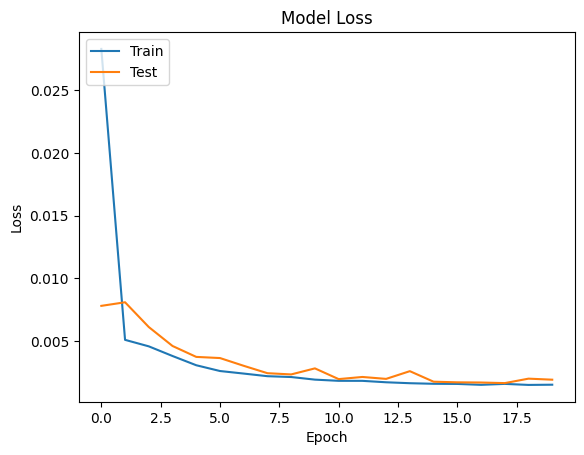

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

96/96 [==============================] - 1s 7ms/step


In [ ]:
# Inverting predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

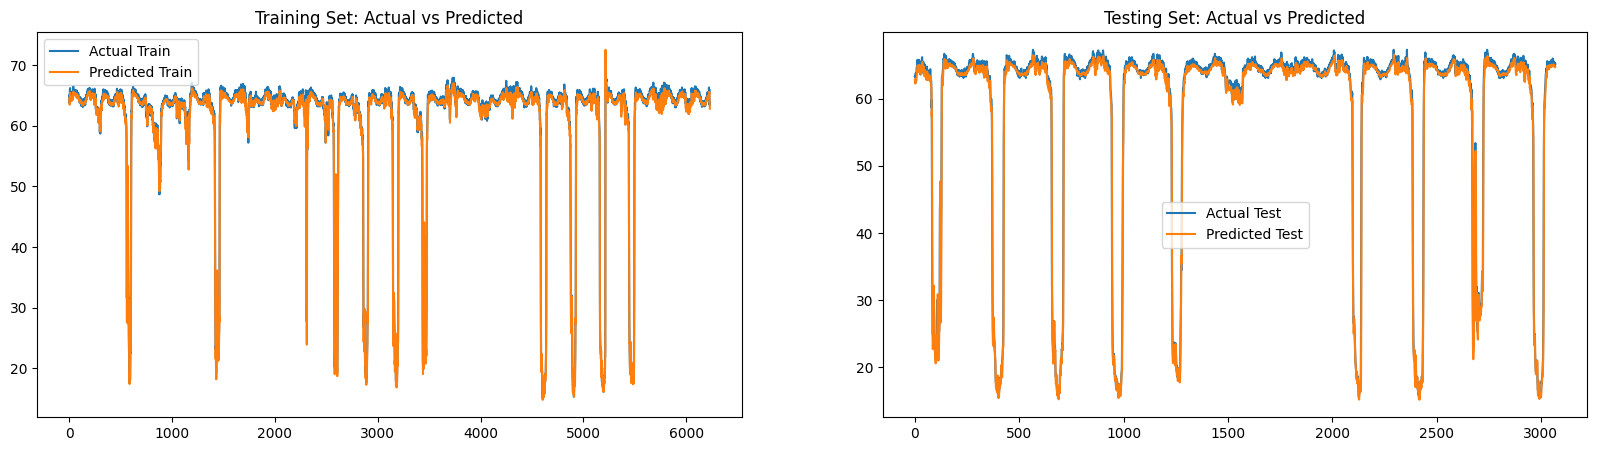

In [ ]:
# Plotting actual vs predictions for training and testing sets
plt.figure(figsize=(20,5))

# Training set
plt.subplot(1,2,1)
plt.plot(y_train_inv[:,0], label='Actual Train')
plt.plot(train_predict[:,0], label='Predicted Train')
plt.title('Training Set: Actual vs Predicted')
plt.legend()

# Testing set
plt.subplot(1,2,2)
plt.plot(y_test_inv[:,0], label='Actual Test')
plt.plot(test_predict[:,0], label='Predicted Test')
plt.title('Testing Set: Actual vs Predicted')
plt.legend()

plt.show()

### Predection and Evaluation

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=2))  # for predicting both speed and flow
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), shuffle=False)

In [ ]:
# Predictions
y_pred = model.predict(X_test)

96/96 [==============================] - 0s 4ms/step


In [ ]:
# Inverse scale the predictions
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)


In [ ]:
# Calculate MAE and RMSE for speed
mae_speed = mean_absolute_error(y_test_actual[:, 0], y_pred_actual[:, 0])
rmse_speed = np.sqrt(mean_squared_error(y_test_actual[:, 0], y_pred_actual[:, 0]))

# Calculate MAE and RMSE for flow
mae_flow = mean_absolute_error(y_test_actual[:, 1], y_pred_actual[:, 1])
rmse_flow = np.sqrt(mean_squared_error(y_test_actual[:, 1], y_pred_actual[:, 1]))

print(f"MAE for Speed: {mae_speed}")
print(f"RMSE for Speed: {rmse_speed}")
print(f"MAE for Flow: {mae_flow}")
print(f"RMSE for Flow: {rmse_flow}")


MAE for Speed: 0.7527353213431391
RMSE for Speed: 1.3931318490621625
MAE for Flow: 17.766394154800267
RMSE for Flow: 24.777751493189594


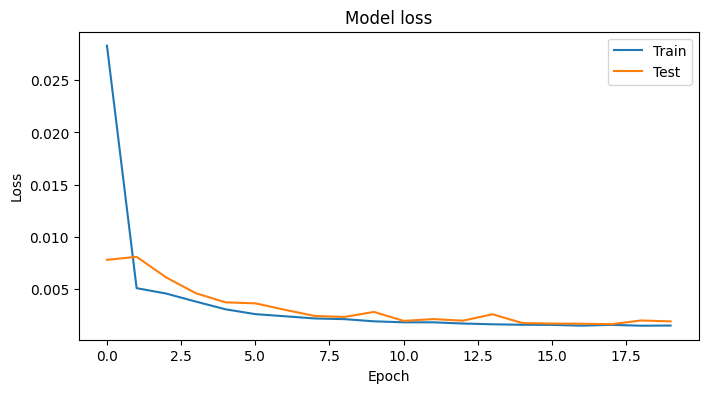

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [ ]:
# 1.Residuals Plot
residuals = y_test - y_pred

plt.figure(figsize=(15, 6))
plt.plot(residuals, label='Residuals', color='green')
plt.title('Residuals: Difference between Actual and Predicted')
plt.ylabel('Residuals')
plt.xlabel('Time')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(15, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# DataFrame to store the results
results_df = pd.DataFrame(columns=['Epochs', 'Batch_Size', 'MAE_Speed', 'RMSE_Speed', 'MAE_Flow', 'RMSE_Flow'])

# Try different numbers of epochs and batch sizes
for epochs in [5, 10, 20]:
    for batch_size in [16, 32, 64]:
        # Define the LSTM model
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(2))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

        # Make predictions
        y_pred = model.predict(X_test)

        # Inverse transform the predictions and actual values
        y_pred_actual = scaler.inverse_transform(y_pred)
        y_test_actual = scaler.inverse_transform(y_test)

        # Calculate MAE and RMSE for speed and flow
        mae_speed = mean_absolute_error(y_test_actual[:, 0], y_pred_actual[:, 0])
        rmse_speed = np.sqrt(mean_squared_error(y_test_actual[:, 0], y_pred_actual[:, 0]))
        mae_flow = mean_absolute_error(y_test_actual[:, 1], y_pred_actual[:, 1])
        rmse_flow = np.sqrt(mean_squared_error(y_test_actual[:, 1], y_pred_actual[:, 1]))

        # Append the results
        results_df = results_df.append({
            'Epochs': epochs,
            'Batch_Size': batch_size,
            'MAE_Speed': mae_speed,
            'RMSE_Speed': rmse_speed,
            'MAE_Flow': mae_flow,
            'RMSE_Flow': rmse_flow
        }, ignore_index=True)

Epoch 1/5
390/390 [==============================] - 9s 12ms/step - loss: 0.0156
Epoch 2/5
390/390 [==============================] - 8s 20ms/step - loss: 0.0043
Epoch 3/5
390/390 [==============================] - 8s 20ms/step - loss: 0.0032
Epoch 4/5
390/390 [==============================] - 5s 12ms/step - loss: 0.0026
Epoch 5/5
96/96 [==============================] - 2s 6ms/step


<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/5
195/195 [==============================] - 7s 13ms/step - loss: 0.0247
Epoch 2/5
195/195 [==============================] - 3s 16ms/step - loss: 0.0048
Epoch 3/5
195/195 [==============================] - 4s 22ms/step - loss: 0.0043
Epoch 4/5
195/195 [==============================] - 4s 19ms/step - loss: 0.0036
Epoch 5/5
96/96 [==============================] - 1s 5ms/step


<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/5
98/98 [==============================] - 7s 23ms/step - loss: 0.0281
Epoch 2/5
98/98 [==============================] - 2s 22ms/step - loss: 0.0052
Epoch 3/5
98/98 [==============================] - 2s 19ms/step - loss: 0.0049
Epoch 4/5
98/98 [==============================] - 1s 15ms/step - loss: 0.0046
Epoch 5/5
96/96 [==============================] - 1s 4ms/step


<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/10
390/390 [==============================] - 10s 16ms/step - loss: 0.0130
Epoch 2/10
390/390 [==============================] - 6s 16ms/step - loss: 0.0044
Epoch 3/10
390/390 [==============================] - 5s 13ms/step - loss: 0.0032
Epoch 4/10
390/390 [==============================] - 6s 15ms/step - loss: 0.0026
Epoch 5/10
390/390 [==============================] - 6s 15ms/step - loss: 0.0021
Epoch 6/10
390/390 [==============================] - 5s 12ms/step - loss: 0.0019
Epoch 7/10
390/390 [==============================] - 5s 13ms/step - loss: 0.0018
Epoch 8/10
390/390 [==============================] - 7s 17ms/step - loss: 0.0017
Epoch 9/10
390/390 [==============================] - 5s 12ms/step - loss: 0.0016
Epoch 10/10
96/96 [==============================] - 1s 4ms/step


<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/10
195/195 [==============================] - 8s 20ms/step - loss: 0.0255
Epoch 2/10
195/195 [==============================] - 4s 19ms/step - loss: 0.0048
Epoch 3/10
195/195 [==============================] - 2s 13ms/step - loss: 0.0043
Epoch 4/10
195/195 [==============================] - 2s 13ms/step - loss: 0.0037
Epoch 5/10
195/195 [==============================] - 3s 13ms/step - loss: 0.0030
Epoch 6/10
195/195 [==============================] - 3s 13ms/step - loss: 0.0025
Epoch 7/10
195/195 [==============================] - 4s 20ms/step - loss: 0.0023
Epoch 8/10
195/195 [==============================] - 4s 19ms/step - loss: 0.0022
Epoch 9/10
195/195 [==============================] - 3s 13ms/step - loss: 0.0020
Epoch 10/10
96/96 [==============================] - 2s 5ms/step


<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/10
98/98 [==============================] - 7s 24ms/step - loss: 0.0491
Epoch 2/10
98/98 [==============================] - 2s 24ms/step - loss: 0.0053
Epoch 3/10
98/98 [==============================] - 2s 18ms/step - loss: 0.0050
Epoch 4/10
98/98 [==============================] - 1s 15ms/step - loss: 0.0047
Epoch 5/10
98/98 [==============================] - 2s 16ms/step - loss: 0.0044
Epoch 6/10
98/98 [==============================] - 1s 15ms/step - loss: 0.0041
Epoch 7/10
98/98 [==============================] - 2s 20ms/step - loss: 0.0037
Epoch 8/10
98/98 [==============================] - 2s 24ms/step - loss: 0.0032
Epoch 9/10
98/98 [==============================] - 2s 25ms/step - loss: 0.0028
Epoch 10/10
96/96 [==============================] - 2s 7ms/step


<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
390/390 [==============================] - 9s 12ms/step - loss: 0.0162
Epoch 2/20
390/390 [==============================] - 6s 14ms/step - loss: 0.0042
Epoch 3/20
390/390 [==============================] - 6s 17ms/step - loss: 0.0031
Epoch 4/20
390/390 [==============================] - 5s 12ms/step - loss: 0.0025
Epoch 5/20
390/390 [==============================] - 5s 13ms/step - loss: 0.0021
Epoch 6/20
390/390 [==============================] - 7s 18ms/step - loss: 0.0019
Epoch 7/20
390/390 [==============================] - 5s 13ms/step - loss: 0.0017
Epoch 8/20
390/390 [==============================] - 5s 12ms/step - loss: 0.0017
Epoch 9/20
390/390 [==============================] - 7s 17ms/step - loss: 0.0016
Epoch 10/20
390/390 [==============================] - 5s 14ms/step - loss: 0.0016
Epoch 11/20
390/390 [==============================] - 5s 12ms/step - loss: 0.0015
Epoch 12/20
390/390 [==============================] - 6s 15ms/step - loss: 0.0015
Epoch 13/20
3

<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
195/195 [==============================] - 9s 20ms/step - loss: 0.0214
Epoch 2/20
195/195 [==============================] - 2s 13ms/step - loss: 0.0048
Epoch 3/20
195/195 [==============================] - 2s 12ms/step - loss: 0.0042
Epoch 4/20
195/195 [==============================] - 2s 13ms/step - loss: 0.0033
Epoch 5/20
195/195 [==============================] - 2s 13ms/step - loss: 0.0028
Epoch 6/20
195/195 [==============================] - 4s 19ms/step - loss: 0.0024
Epoch 7/20
195/195 [==============================] - 4s 20ms/step - loss: 0.0022
Epoch 8/20
195/195 [==============================] - 3s 14ms/step - loss: 0.0020
Epoch 9/20
195/195 [==============================] - 2s 13ms/step - loss: 0.0019
Epoch 10/20
195/195 [==============================] - 3s 13ms/step - loss: 0.0018
Epoch 11/20
195/195 [==============================] - 2s 13ms/step - loss: 0.0017
Epoch 12/20
195/195 [==============================] - 3s 17ms/step - loss: 0.0017
Epoch 13/20
1

<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
98/98 [==============================] - 7s 16ms/step - loss: 0.0398
Epoch 2/20
98/98 [==============================] - 1s 14ms/step - loss: 0.0054
Epoch 3/20
98/98 [==============================] - 1s 15ms/step - loss: 0.0050
Epoch 4/20
98/98 [==============================] - 1s 14ms/step - loss: 0.0047
Epoch 5/20
98/98 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 6/20
98/98 [==============================] - 1s 15ms/step - loss: 0.0040
Epoch 7/20
98/98 [==============================] - 1s 15ms/step - loss: 0.0037
Epoch 8/20
98/98 [==============================] - 2s 22ms/step - loss: 0.0033
Epoch 9/20
98/98 [==============================] - 2s 23ms/step - loss: 0.0030
Epoch 10/20
98/98 [==============================] - 2s 23ms/step - loss: 0.0028
Epoch 11/20
98/98 [==============================] - 2s 20ms/step - loss: 0.0025
Epoch 12/20
98/98 [==============================] - 1s 14ms/step - loss: 0.0024
Epoch 13/20
98/98 [==================

<ipython-input-41-9e58489d5f1b>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [ ]:
results_df

,Epochs,Batch_Size,MAE_Speed,RMSE_Speed,MAE_Flow,RMSE_Flow
0,5.0,16.0,1.271062,2.393524,17.998710,24.273767
1,5.0,32.0,1.756546,3.199292,18.606941,25.982119
2,5.0,64.0,1.856520,4.362656,21.266919,29.144882
3,10.0,16.0,0.619642,1.273503,17.613143,23.064974
4,10.0,32.0,0.985150,1.893483,16.682740,23.365501
5,10.0,64.0,1.387382,2.782454,18.725668,25.800403
6,20.0,16.0,0.845170,1.315267,16.885207,23.552242
7,20.0,32.0,0.693740,1.274607,16.057368,22.398134
8,20.0,64.0,0.941949,1.884959,16.640874,22.727654


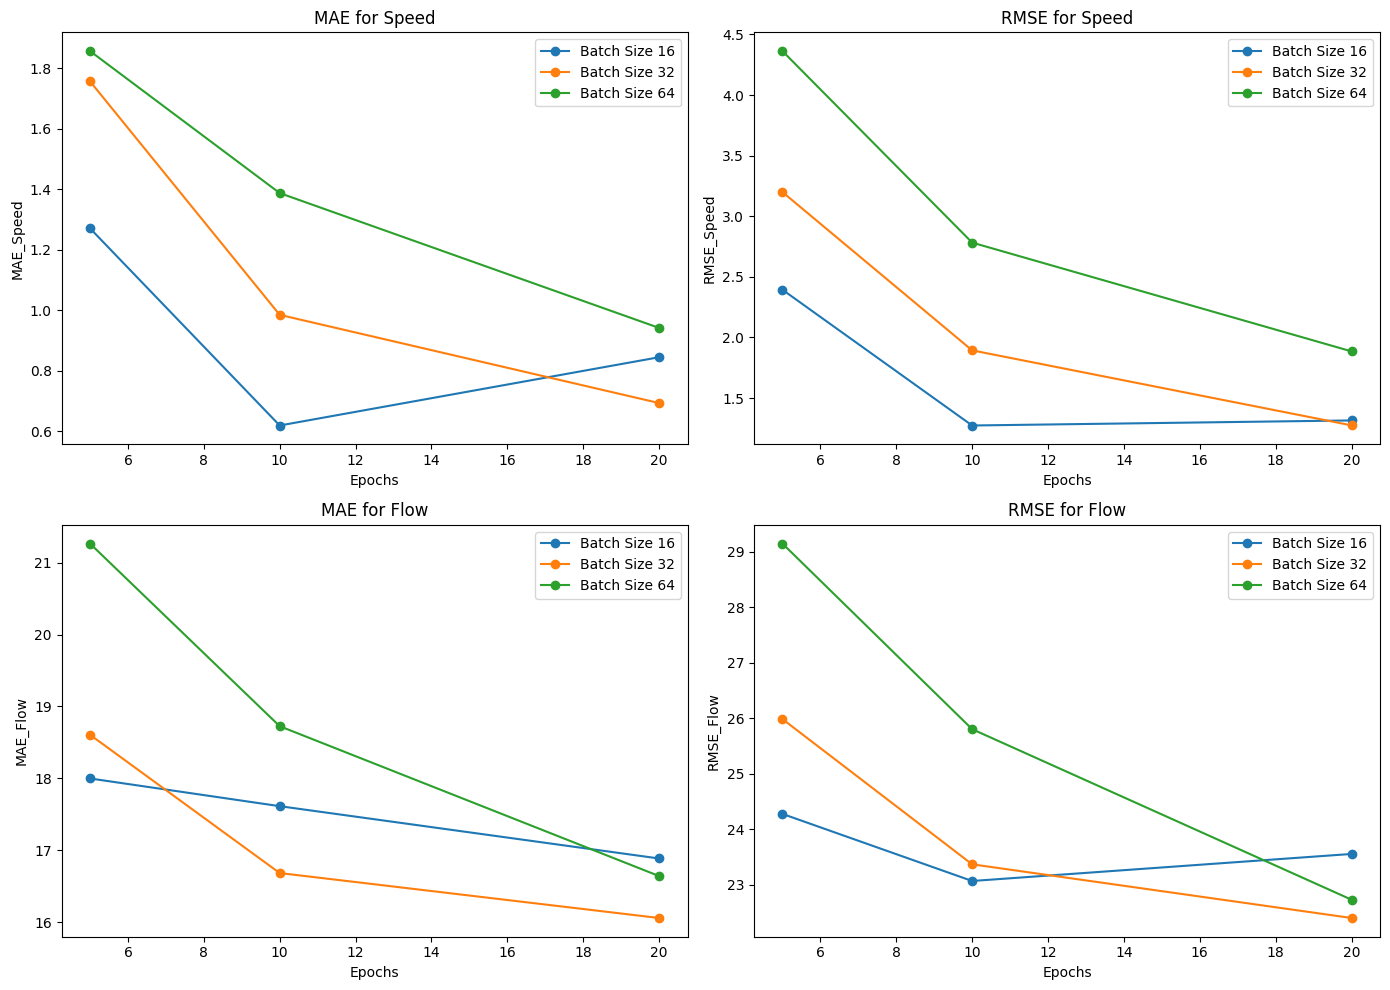

In [ ]:
# Prepare the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
batch_sizes = results_df['Batch_Size'].unique()

# Plot each metric in a subplot
metrics = ['MAE_Speed', 'RMSE_Speed', 'MAE_Flow', 'RMSE_Flow']
titles = ['MAE for Speed', 'RMSE for Speed', 'MAE for Flow', 'RMSE for Flow']

for i, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, i+1)
    for batch_size in batch_sizes:
        subset = results_df[results_df['Batch_Size'] == batch_size]
        ax.plot(subset['Epochs'], subset[metric], '-o', label=f'Batch Size {int(batch_size)}')
    ax.set_title(titles[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout()
plt.show()

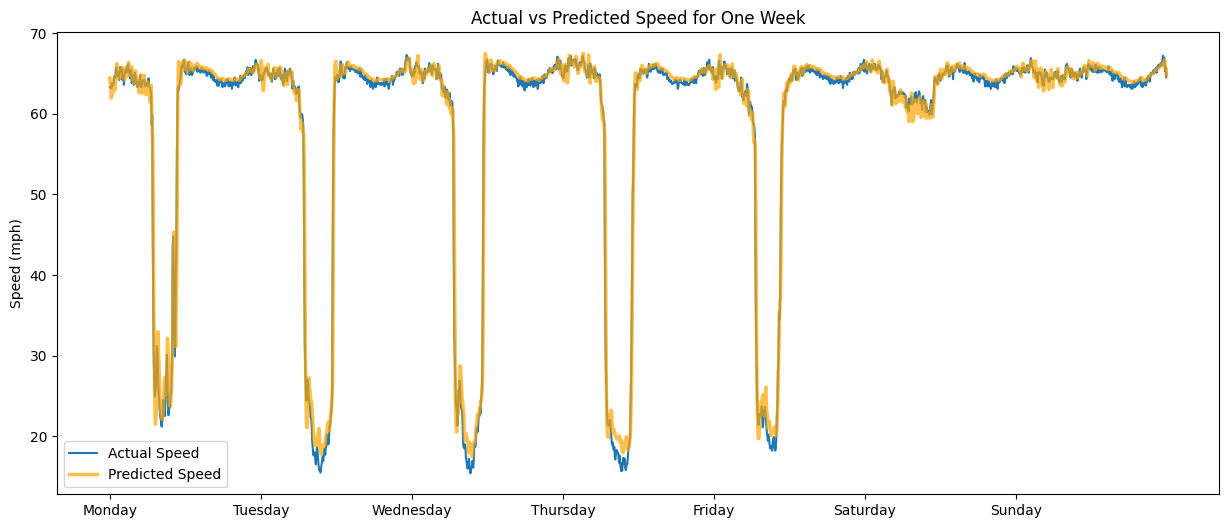

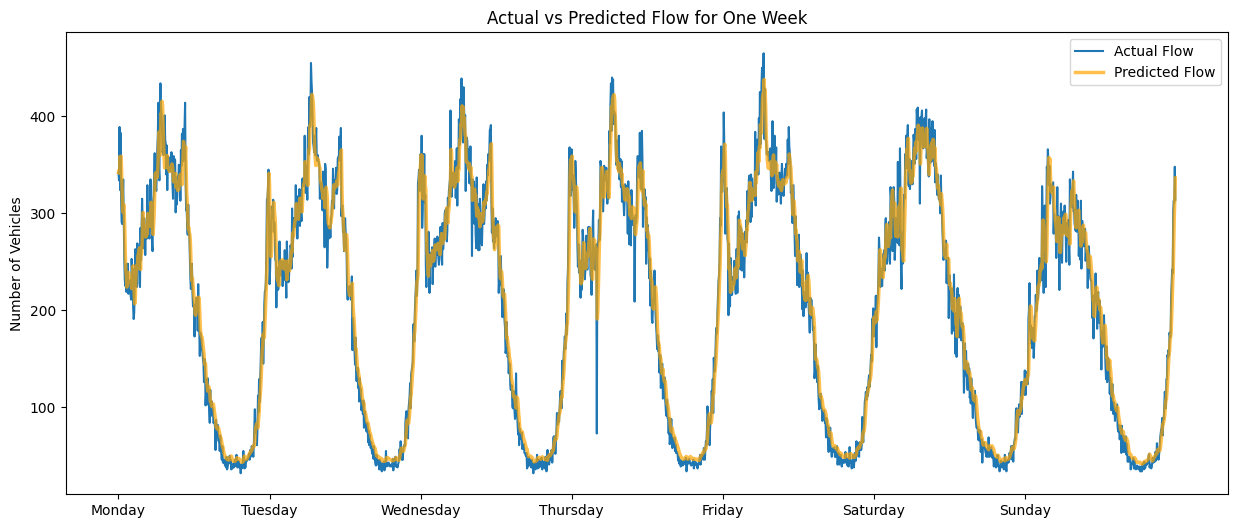

In [ ]:
# Define the number of data points for one day and one week
points_per_day = 12 * 24  # 12 data points/hour * 24 hours/day
week_points = points_per_day * 7  # for one week

# Define the tick locations for days of the week
tick_locations = [i*points_per_day for i in range(7)]
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plotting Actual vs Predicted for Speed for one week
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:week_points, 0], label='Actual Speed')
plt.plot(y_pred_actual[:week_points, 0], label='Predicted Speed', color='orange',linewidth=2.5,alpha=0.7)
plt.title('Actual vs Predicted Speed for One Week')
plt.xticks(tick_locations, day_names)
plt.ylabel('Speed (mph)')
plt.legend()
plt.show()

# Plotting Actual vs Predicted for Flow for one week
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:week_points, 1], label='Actual Flow')
plt.plot(y_pred_actual[:week_points, 1], label='Predicted Flow',color='orange',linewidth=2.5, alpha=0.7)
plt.title('Actual vs Predicted Flow for One Week')
plt.xticks(tick_locations, day_names)
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()


## Other sensors

In [ ]:
import numpy as np

# Assuming 'combined_data' is your full dataset and 'scaler' is already fit on the original sensor's data

# Let's say we're now working with a new sensor ID 400792
new_sensor_speed_col = '400792_speed'
new_sensor_flow_col = '400792_flow'

# Extracting new sensor data
new_sensor_data = combined_data[[new_sensor_speed_col, new_sensor_flow_col]]

# Convert the DataFrame to a NumPy array before transformation to avoid column name mismatch
scaled_new_sensor_data = scaler.transform(new_sensor_data.values)

# Create sequences from the scaled new sensor data
X_new_sensor, y_new_sensor = create_sequences(scaled_new_sensor_data, seq_length)

# Reshape the data for the LSTM model, as the model expects the input shape to be [samples, time steps, features]
X_new_sensor_reshaped = np.reshape(X_new_sensor, (X_new_sensor.shape[0], seq_length - 1, 2))

# Now you can use the model to predict on the new sensor data
y_new_sensor_pred = model.predict(X_new_sensor_reshaped)

# Inverse transform the predictions and actual values to their original scale
y_new_sensor_pred_actual = scaler.inverse_transform(y_new_sensor_pred)
y_new_sensor_actual = scaler.inverse_transform(y_new_sensor)

# Calculate MAE and RMSE for the new sensor data
mae_new_sensor_speed = mean_absolute_error(y_new_sensor_actual[:, 0], y_new_sensor_pred_actual[:, 0])
rmse_new_sensor_speed = np.sqrt(mean_squared_error(y_new_sensor_actual[:, 0], y_new_sensor_pred_actual[:, 0]))
mae_new_sensor_flow = mean_absolute_error(y_new_sensor_actual[:, 1], y_new_sensor_pred_actual[:, 1])
rmse_new_sensor_flow = np.sqrt(mean_squared_error(y_new_sensor_actual[:, 1], y_new_sensor_pred_actual[:, 1]))

# Output the performance metrics for the new sensor data
print(f"Sensor: {new_sensor_speed_col}")
print(f"MAE for Speed: {mae_new_sensor_speed}")
print(f"RMSE for Speed: {rmse_new_sensor_speed}")
print(f"MAE for Flow: {mae_new_sensor_flow}")
print(f"RMSE for Flow: {rmse_new_sensor_flow}")



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


291/291 [==============================] - 2s 5ms/step
Sensor: 400792_speed
MAE for Speed: 1.0477687123359547
RMSE for Speed: 2.157485224459299
MAE for Flow: 13.327447115336918
RMSE for Flow: 18.417740693750407


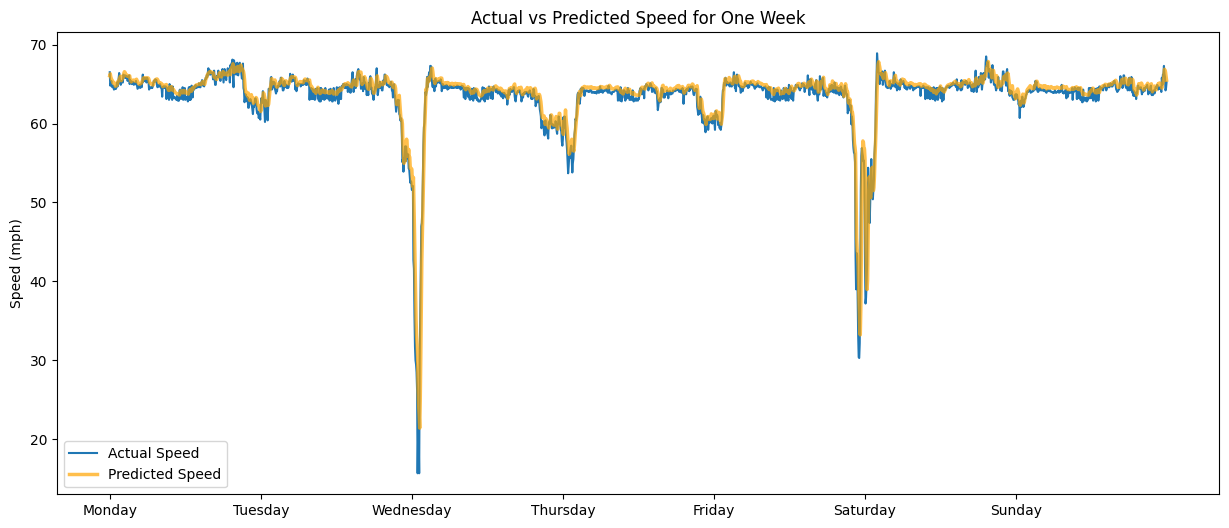

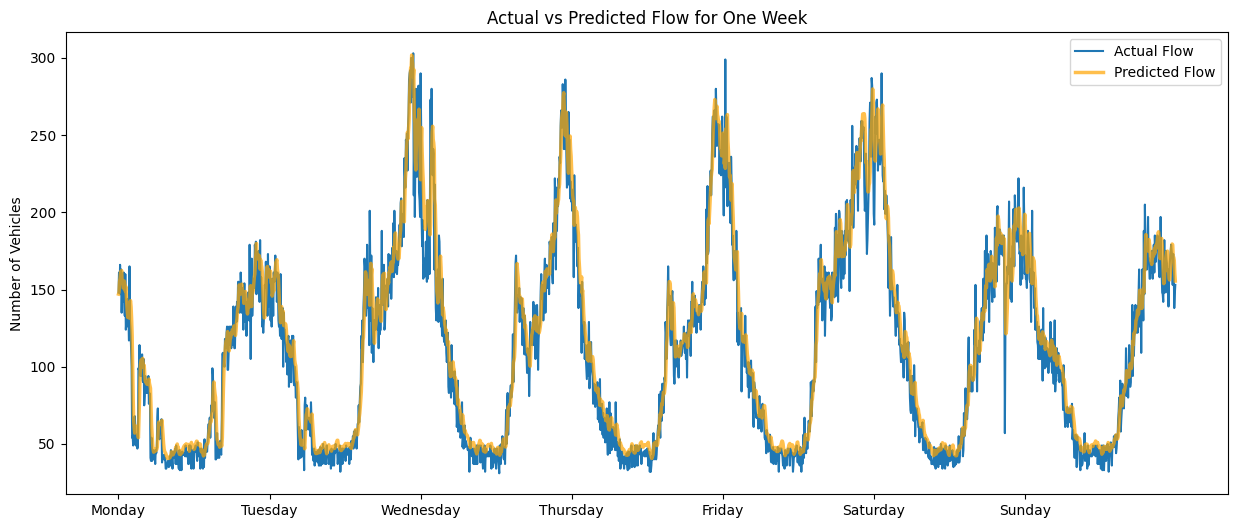

In [ ]:
# Define the number of data points for one day and one week
points_per_day = 12 * 24  # 12 data points/hour * 24 hours/day
week_points = points_per_day * 7  # for one week

# Define the tick locations for days of the week
tick_locations = [i*points_per_day for i in range(7)]
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Plotting Actual vs Predicted for Speed for one week
plt.figure(figsize=(15, 6))
plt.plot(y_new_sensor_actual[:week_points, 0], label='Actual Speed')
plt.plot(y_new_sensor_pred_actual[:week_points, 0], label='Predicted Speed',color='orange',linewidth=2.5, alpha=0.7)
plt.title('Actual vs Predicted Speed for One Week')
plt.xticks(tick_locations, day_names)
plt.ylabel('Speed (mph)')
plt.legend()
plt.show()

# Plotting Actual vs Predicted for Flow for one week
plt.figure(figsize=(15, 6))
plt.plot(y_new_sensor_actual[:week_points, 1], label='Actual Flow')
plt.plot(y_new_sensor_pred_actual[:week_points, 1], label='Predicted Flow', color='orange',linewidth=2.5,alpha=0.7)
plt.title('Actual vs Predicted Flow for One Week')
plt.xticks(tick_locations, day_names)
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [ ]:
# Define the number of sensors to evaluate
num_sensors_to_evaluate = 5

# Randomly select sensor columns excluding the original training sensor
sensor_columns = [col for col in combined_data.columns if 'speed' in col and '400017' not in col]
selected_sensors = random.sample(sensor_columns, num_sensors_to_evaluate)

# Dictionary to store performance metrics for each sensor
sensor_performance = {}

# Evaluate each selected sensor
for sensor in selected_sensors:
    # Extract the corresponding flow column
    flow_col = sensor.replace('speed', 'flow')

    # Extracting sensor data
    sensor_data = combined_data[[sensor, flow_col]].dropna()

    # Convert the DataFrame to a NumPy array before transformation
    scaled_sensor_data = scaler.transform(sensor_data.values)

    # Create sequences from the scaled sensor data
    X_sensor, y_sensor = create_sequences(scaled_sensor_data, seq_length)

    # Reshape the data for the LSTM model
    X_sensor_reshaped = np.reshape(X_sensor, (X_sensor.shape[0], seq_length - 1, 2))

    # Make predictions with the model
    y_sensor_pred = model.predict(X_sensor_reshaped)

    # Inverse transform the predictions and actual values to their original scale
    y_sensor_pred_actual = scaler.inverse_transform(y_sensor_pred)
    y_sensor_actual = scaler.inverse_transform(y_sensor)

    # Calculate MAE and RMSE for speed and flow
    mae_sensor_speed = mean_absolute_error(y_sensor_actual[:, 0], y_sensor_pred_actual[:, 0])
    rmse_sensor_speed = np.sqrt(mean_squared_error(y_sensor_actual[:, 0], y_sensor_pred_actual[:, 0]))
    mae_sensor_flow = mean_absolute_error(y_sensor_actual[:, 1], y_sensor_pred_actual[:, 1])
    rmse_sensor_flow = np.sqrt(mean_squared_error(y_sensor_actual[:, 1], y_sensor_pred_actual[:, 1]))

    # Store the performance metrics
    sensor_performance[sensor] = {
        'MAE_Speed': mae_sensor_speed,
        'RMSE_Speed': rmse_sensor_speed,
        'MAE_Flow': mae_sensor_flow,
        'RMSE_Flow': rmse_sensor_flow
    }

# Convert the performance metrics to a DataFrame for easier comparison
performance_df = pd.DataFrame.from_dict(sensor_performance, orient='index')

# Now you can compare the performance across different sensors
performance_df

  9/291 [..............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  9/291 [..............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  9/291 [..............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 22/291 [=>............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 23/291 [=>............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


291/291 [==============================] - 1s 5ms/step


,MAE_Speed,RMSE_Speed,MAE_Flow,RMSE_Flow
400582_speed,0.948623,1.815125,12.680855,18.422179
400030_speed,1.478791,3.002286,18.674793,26.237120
409525_speed,0.871372,1.714272,14.860868,24.872534
400172_speed,1.193145,1.808139,20.425010,27.189862
402061_speed,0.985100,1.555869,17.400398,23.931169


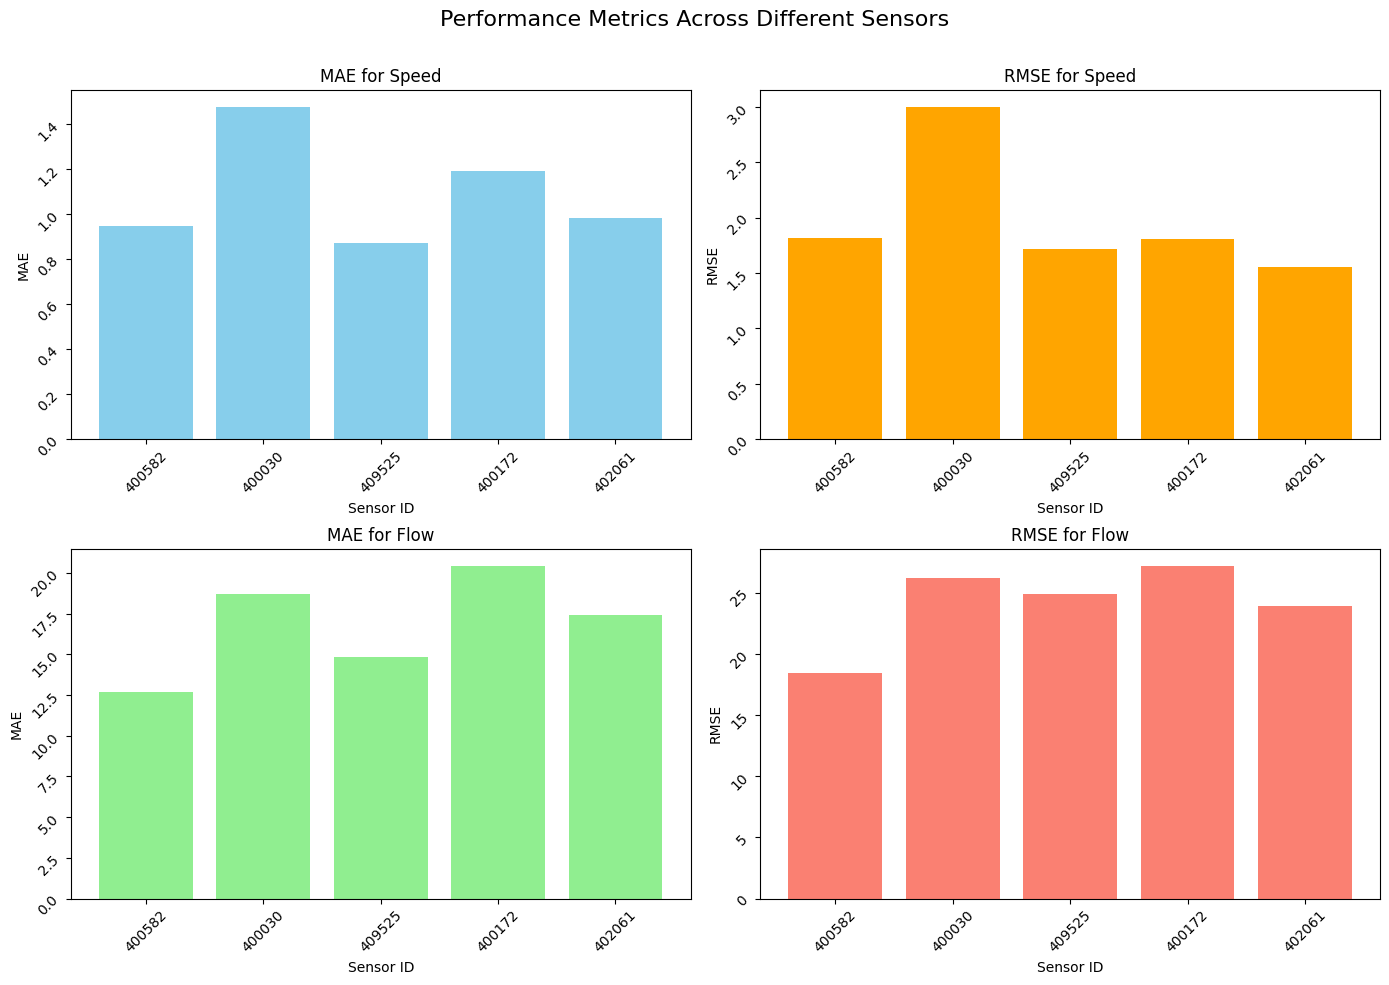

In [ ]:
# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Metrics Across Different Stations', fontsize=16)

# Prepare the sensor names by stripping out non-numeric parts for the plot
sensor_names = [name.split('_')[0] for name in performance_df.index]

# MAE for Speed
axs[0, 0].bar(sensor_names, performance_df['MAE_Speed'], color='skyblue')
axs[0, 0].set_title('MAE for Speed')
axs[0, 0].set_xlabel('Sensor ID')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].tick_params(labelrotation=45)

# RMSE for Speed
axs[0, 1].bar(sensor_names, performance_df['RMSE_Speed'], color='orange')
axs[0, 1].set_title('RMSE for Speed')
axs[0, 1].set_xlabel('Sensor ID')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].tick_params(labelrotation=45)

# MAE for Flow
axs[1, 0].bar(sensor_names, performance_df['MAE_Flow'], color='lightgreen')
axs[1, 0].set_title('MAE for Flow')
axs[1, 0].set_xlabel('Sensor ID')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].tick_params(labelrotation=45)

# RMSE for Flow
axs[1, 1].bar(sensor_names, performance_df['RMSE_Flow'], color='salmon')
axs[1, 1].set_title('RMSE for Flow')
axs[1, 1].set_xlabel('Sensor ID')
axs[1, 1].set_ylabel('RMSE')
axs[1, 1].tick_params(labelrotation=45)

# Adjust the layout so labels don't overlap
plt.tight_layout()

# Add an extra space at the top for the suptitle
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()

In [ ]:

new_sensor_speed_col = '400582_speed'
new_sensor_flow_col = '400582_flow'

# Extracting new sensor data
new_sensor_data = combined_data[[new_sensor_speed_col, new_sensor_flow_col]]

# Convert the DataFrame to a NumPy array before transformation to avoid column name mismatch
scaled_new_sensor_data = scaler.transform(new_sensor_data.values)

# Create sequences from the scaled new sensor data
X_new_sensor, y_new_sensor = create_sequences(scaled_new_sensor_data, seq_length)

# Reshape the data for the LSTM model, as the model expects the input shape to be [samples, time steps, features]
X_new_sensor_reshaped = np.reshape(X_new_sensor, (X_new_sensor.shape[0], seq_length - 1, 2))

# Now you can use the model to predict on the new sensor data
y_new_sensor_pred = model.predict(X_new_sensor_reshaped)

# Inverse transform the predictions and actual values to their original scale
y_new_sensor_pred_actual = scaler.inverse_transform(y_new_sensor_pred)
y_new_sensor_actual = scaler.inverse_transform(y_new_sensor)

# Calculate MAE and RMSE for the new sensor data
mae_new_sensor_speed = mean_absolute_error(y_new_sensor_actual[:, 0], y_new_sensor_pred_actual[:, 0])
rmse_new_sensor_speed = np.sqrt(mean_squared_error(y_new_sensor_actual[:, 0], y_new_sensor_pred_actual[:, 0]))
mae_new_sensor_flow = mean_absolute_error(y_new_sensor_actual[:, 1], y_new_sensor_pred_actual[:, 1])
rmse_new_sensor_flow = np.sqrt(mean_squared_error(y_new_sensor_actual[:, 1], y_new_sensor_pred_actual[:, 1]))

# Output the performance metrics for the new sensor data
print(f"Sensor: {new_sensor_speed_col}")
print(f"MAE for Speed: {mae_new_sensor_speed}")
print(f"RMSE for Speed: {rmse_new_sensor_speed}")
print(f"MAE for Flow: {mae_new_sensor_flow}")
print(f"RMSE for Flow: {rmse_new_sensor_flow}")

 10/291 [>.............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


291/291 [==============================] - 3s 9ms/step
Sensor: 400582_speed
MAE for Speed: 0.9486231636575577
RMSE for Speed: 1.8151250669634447
MAE for Flow: 12.680854691353902
RMSE for Flow: 18.422179120550048


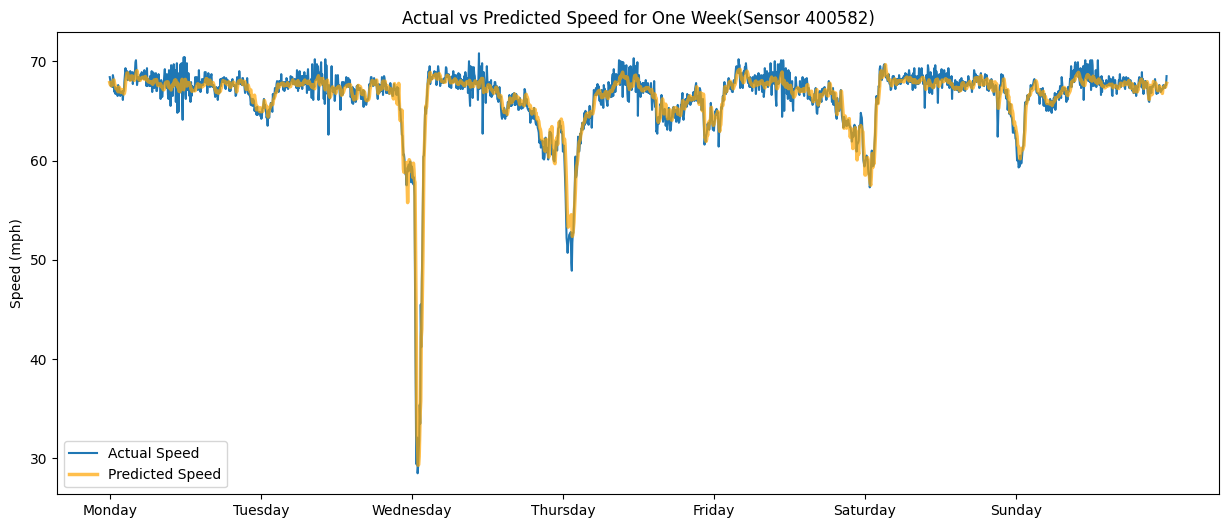

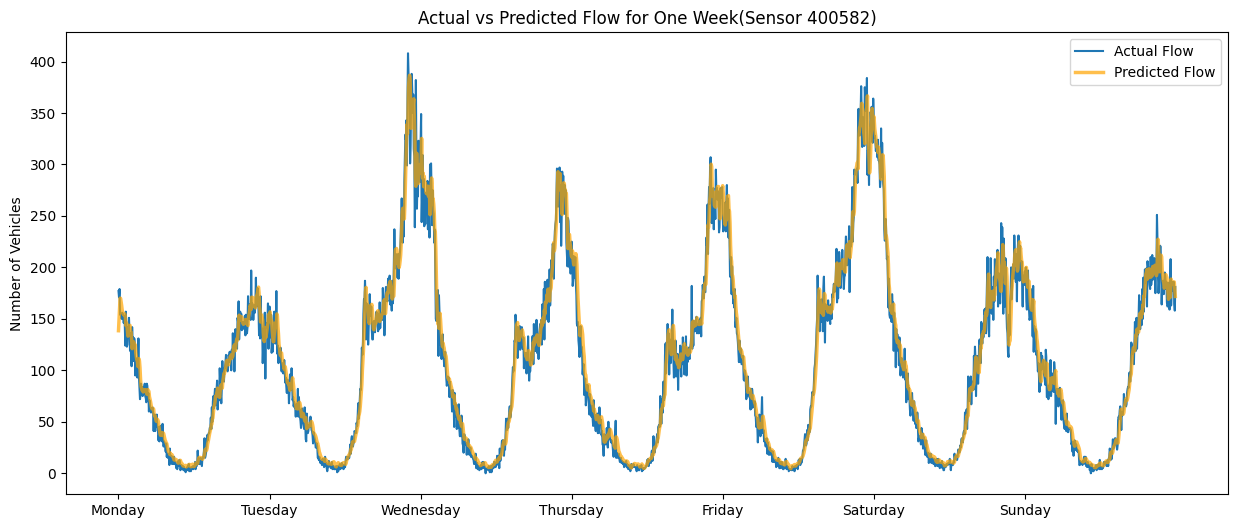

In [ ]:
# Plotting Actual vs Predicted for Speed for one week
plt.figure(figsize=(15, 6))
plt.plot(y_new_sensor_actual[:week_points, 0], label='Actual Speed')
plt.plot(y_new_sensor_pred_actual[:week_points, 0], label='Predicted Speed',color='orange',linewidth=2.5, alpha=0.7)
plt.title('Actual vs Predicted Speed for One Week(Sensor 400582)')
plt.xticks(tick_locations, day_names)
plt.ylabel('Speed (mph)')
plt.legend()
plt.show()

# Plotting Actual vs Predicted for Flow for one week
plt.figure(figsize=(15, 6))
plt.plot(y_new_sensor_actual[:week_points, 1], label='Actual Flow')
plt.plot(y_new_sensor_pred_actual[:week_points, 1], label='Predicted Flow', color='orange',linewidth=2.5,alpha=0.7)
plt.title('Actual vs Predicted Flow for One Week(Sensor 400582)')
plt.xticks(tick_locations, day_names)
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [ ]:
new_sensor_speed_col = '400030_speed'
new_sensor_flow_col = '400030_flow'

# Extracting new sensor data
new_sensor_data = combined_data[[new_sensor_speed_col, new_sensor_flow_col]]

# Convert the DataFrame to a NumPy array before transformation to avoid column name mismatch
scaled_new_sensor_data = scaler.transform(new_sensor_data.values)

# Create sequences from the scaled new sensor data
X_new_sensor, y_new_sensor = create_sequences(scaled_new_sensor_data, seq_length)

# Reshape the data for the LSTM model, as the model expects the input shape to be [samples, time steps, features]
X_new_sensor_reshaped = np.reshape(X_new_sensor, (X_new_sensor.shape[0], seq_length - 1, 2))

# Now you can use the model to predict on the new sensor data
y_new_sensor_pred = model.predict(X_new_sensor_reshaped)

# Inverse transform the predictions and actual values to their original scale
y_new_sensor_pred_actual = scaler.inverse_transform(y_new_sensor_pred)
y_new_sensor_actual = scaler.inverse_transform(y_new_sensor)

# Calculate MAE and RMSE for the new sensor data
mae_new_sensor_speed = mean_absolute_error(y_new_sensor_actual[:, 0], y_new_sensor_pred_actual[:, 0])
rmse_new_sensor_speed = np.sqrt(mean_squared_error(y_new_sensor_actual[:, 0], y_new_sensor_pred_actual[:, 0]))
mae_new_sensor_flow = mean_absolute_error(y_new_sensor_actual[:, 1], y_new_sensor_pred_actual[:, 1])
rmse_new_sensor_flow = np.sqrt(mean_squared_error(y_new_sensor_actual[:, 1], y_new_sensor_pred_actual[:, 1]))

# Output the performance metrics for the new sensor data
print(f"Sensor: {new_sensor_speed_col}")
print(f"MAE for Speed: {mae_new_sensor_speed}")
print(f"RMSE for Speed: {rmse_new_sensor_speed}")
print(f"MAE for Flow: {mae_new_sensor_flow}")
print(f"RMSE for Flow: {rmse_new_sensor_flow}")

  8/291 [..............................] - ETA: 2s 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


291/291 [==============================] - 2s 6ms/step
Sensor: 400030_speed
MAE for Speed: 1.4787907146325914
RMSE for Speed: 3.0022862955439424
MAE for Flow: 18.674793093826302
RMSE for Flow: 26.237119843755114


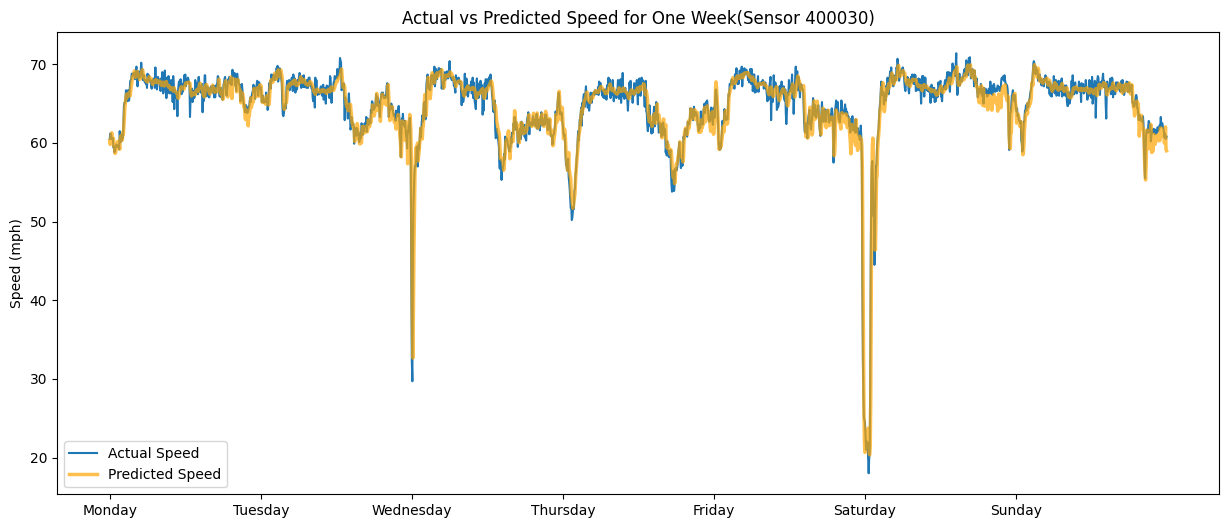

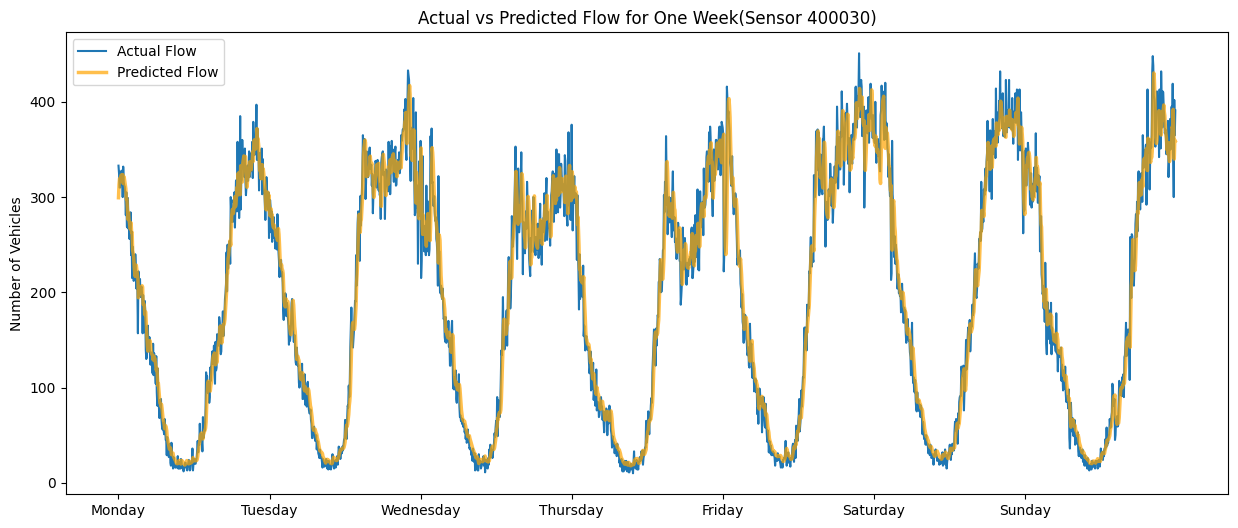

In [ ]:
# Plotting Actual vs Predicted for Speed for one week
plt.figure(figsize=(15, 6))
plt.plot(y_new_sensor_actual[:week_points, 0], label='Actual Speed')
plt.plot(y_new_sensor_pred_actual[:week_points, 0], label='Predicted Speed',color='orange',linewidth=2.5, alpha=0.7)
plt.title('Actual vs Predicted Speed for One Week(Sensor 400030)')
plt.xticks(tick_locations, day_names)
plt.ylabel('Speed (mph)')
plt.legend()
plt.show()

# Plotting Actual vs Predicted for Flow for one week
plt.figure(figsize=(15, 6))
plt.plot(y_new_sensor_actual[:week_points, 1], label='Actual Flow')
plt.plot(y_new_sensor_pred_actual[:week_points, 1], label='Predicted Flow', color='orange',linewidth=2.5,alpha=0.7)
plt.title('Actual vs Predicted Flow for One Week(Sensor 400030)')
plt.xticks(tick_locations, day_names)
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

## Experiment different sequence length

In [ ]:
combined_data = pd.read_csv('/content/drive/MyDrive/San_Jose_Traffic_Pred/combined_data.csv')

In [ ]:
# Extracting speed and flow for sensor 400017
data_400017 = combined_data[['400017_speed', '400017_flow']]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_400017)

In [ ]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        label = data[i + seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
# List of sequence lengths to try
seq_lengths = [5, 10, 15, 20]

# Dictionary to store evaluation results
evaluation_results = {}

# Loop over each sequence length
for seq_length in seq_lengths:
    # Create sequences
    X, y = create_sequences(scaled_data, seq_length)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], seq_length, 2))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_length, 2))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 2)))
    model.add(LSTM(50))
    model.add(Dense(2))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store the evaluation metrics
    evaluation_results[seq_length] = {'MAE': mae, 'RMSE': rmse}

96/96 [==============================] - 1s 6ms/step


In [ ]:
seq_lengths = list(evaluation_results.keys())
maes = [evaluation_results[sl]['MAE'] for sl in seq_lengths]
rmses = [evaluation_results[sl]['RMSE'] for sl in seq_lengths]

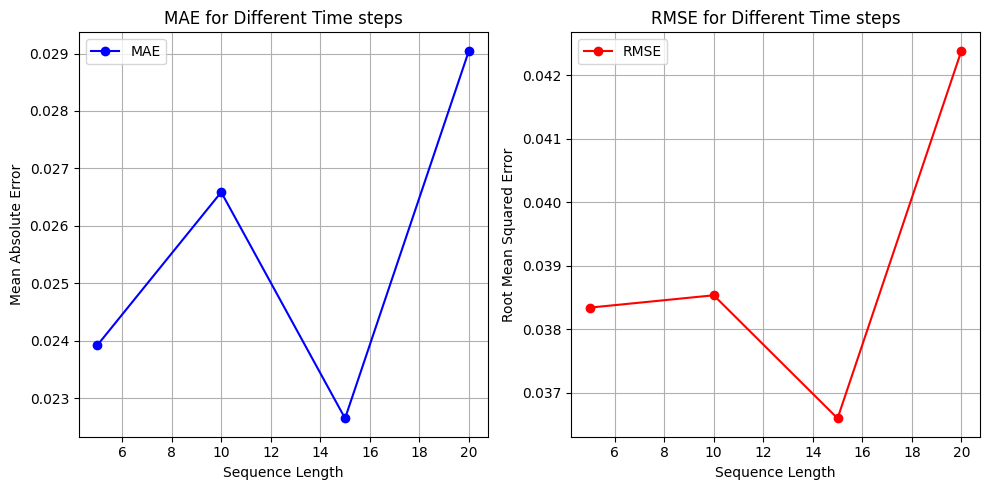

In [ ]:
# Plot MAE and RMSE for different sequence lengths
plt.figure(figsize=(10, 5))

# MAE plot
plt.subplot(1, 2, 1)
plt.plot(seq_lengths, maes, marker='o', color='blue', label='MAE')
plt.title('MAE for Different Time steps')
plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# RMSE plot
plt.subplot(1, 2, 2)
plt.plot(seq_lengths, rmses, marker='o', color='red', label='RMSE')
plt.title('RMSE for Different Time steps')
plt.xlabel('Sequence Length')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()